In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sys

# Custom functions

sys.path.insert(1, '../src')
from custom_plots import *

import shap

# Options
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
%matplotlib inline
sns.set_theme(style="white")

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2


# NOTE THAT SETTING THESE PARAMETERS ELIMINATES "MASK" FUNCTIONALITY ON CMAP
# FONT_SIZE=20
# sns.set(rc={
#     'figure.figsize': (df.shape[1]/2,df.shape[1]/3),
#     'font.size': FONT_SIZE,
#     'axes.titlesize': FONT_SIZE, 
#     'xtick.labelsize': FONT_SIZE, 
#     'ytick.labelsize': FONT_SIZE,
#     'axes.labelsize': FONT_SIZE})

## Import protest data

In [2]:
# Import data from Modeling notebook
engine = create_engine('sqlite:///../data/processed/all_data.db')
with engine.begin() as connection:
    df = pd.read_sql('SELECT * FROM all_modeled_data', connection)
    
df['target_categorical'] = ['Revolution' if x == 1 else "No Revolution" for x in df.target]
df['target30'] = (df.alternative_target < 30).astype('int')
df['target90'] = (df.alternative_target < 90).astype('int')
df['target180'] = (df.alternative_target < 180).astype('int')
df['target365'] = (df.alternative_target < 365).astype('int')
df['duration_until_end_of_regime'] = df.alternative_target
df.drop(['target', 'alternative_target'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14558 entries, 0 to 14557
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            14558 non-null  object 
 1   region                             14558 non-null  object 
 2   protestnumber                      14558 non-null  int64  
 3   protesterviolence                  14558 non-null  int64  
 4   startdate                          14558 non-null  float64
 5   duration_days                      14558 non-null  int64  
 6   participants                       14558 non-null  int64  
 7   participants_category              14558 non-null  object 
 8   demand_labor-wage-dispute          14558 non-null  int64  
 9   demand_land-farm-issue             14558 non-null  int64  
 10  demand_police-brutality            14558 non-null  int64  
 11  demand_political-behavior/process  14558 non-null  int

In [3]:
demands = ['demand_labor-wage-dispute', 'demand_land-farm-issue', 'demand_police-brutality', 'demand_political-behavior/process', 'demand_price-increases/tax-policy', 'demand_removal-of-politician', 'demand_social-restrictions']
binary = demands + ['protesterviolence', 'finittrm', 'military', 'legelec', 'exelec']

continuous = ['protestnumber', 'duration_days', 'participants', 'yrsoffc', 'totalseats', 'startdate', 'liec', 'eiec', 'numvote', 'oppvote', 'gq', 'tensys_strict', 'stabs_strict', 'duration_until_end_of_regime']
categorical = ['region', 'participants_category', 'system', 'country']
targets = ['target30', 'target90', 'target180', 'target365', 'target_categorical']

remainders = df.drop(continuous+categorical+binary+targets, axis=1).columns

if remainders.shape==(0,):
    print("All features successfully bucketed")
else:
    print('Remaining columns to be assigned to various bucket:')
    for col in remainders:
        print(col, '\n', df[col].value_counts(), '\n')

Remaining columns to be assigned to various bucket:
parcomp 
  4     4651
 5     3472
 3     3455
 2     1457
 1      812
 0      242
-88     191
-77     185
-66      93
Name: parcomp, dtype: int64 

parreg 
  2     5710
 5     3472
 3     3035
 4     1805
-88     191
-77     185
-66      93
 1       67
Name: parreg, dtype: int64 

xconst 
  7     5646
 6     2517
 5     2068
 3     1870
 2      865
 4      680
 1      443
-88     191
-77     185
-66      93
Name: xconst, dtype: int64 

xropen 
  4     12340
 0      1263
 2       266
-88      191
-77      185
 3       128
-66       93
 1        92
Name: xropen, dtype: int64 

xrcomp 
  3     7523
 2     3392
 1     1911
 0     1263
-88     191
-77     185
-66      93
Name: xrcomp, dtype: int64 



## Correlation matrix

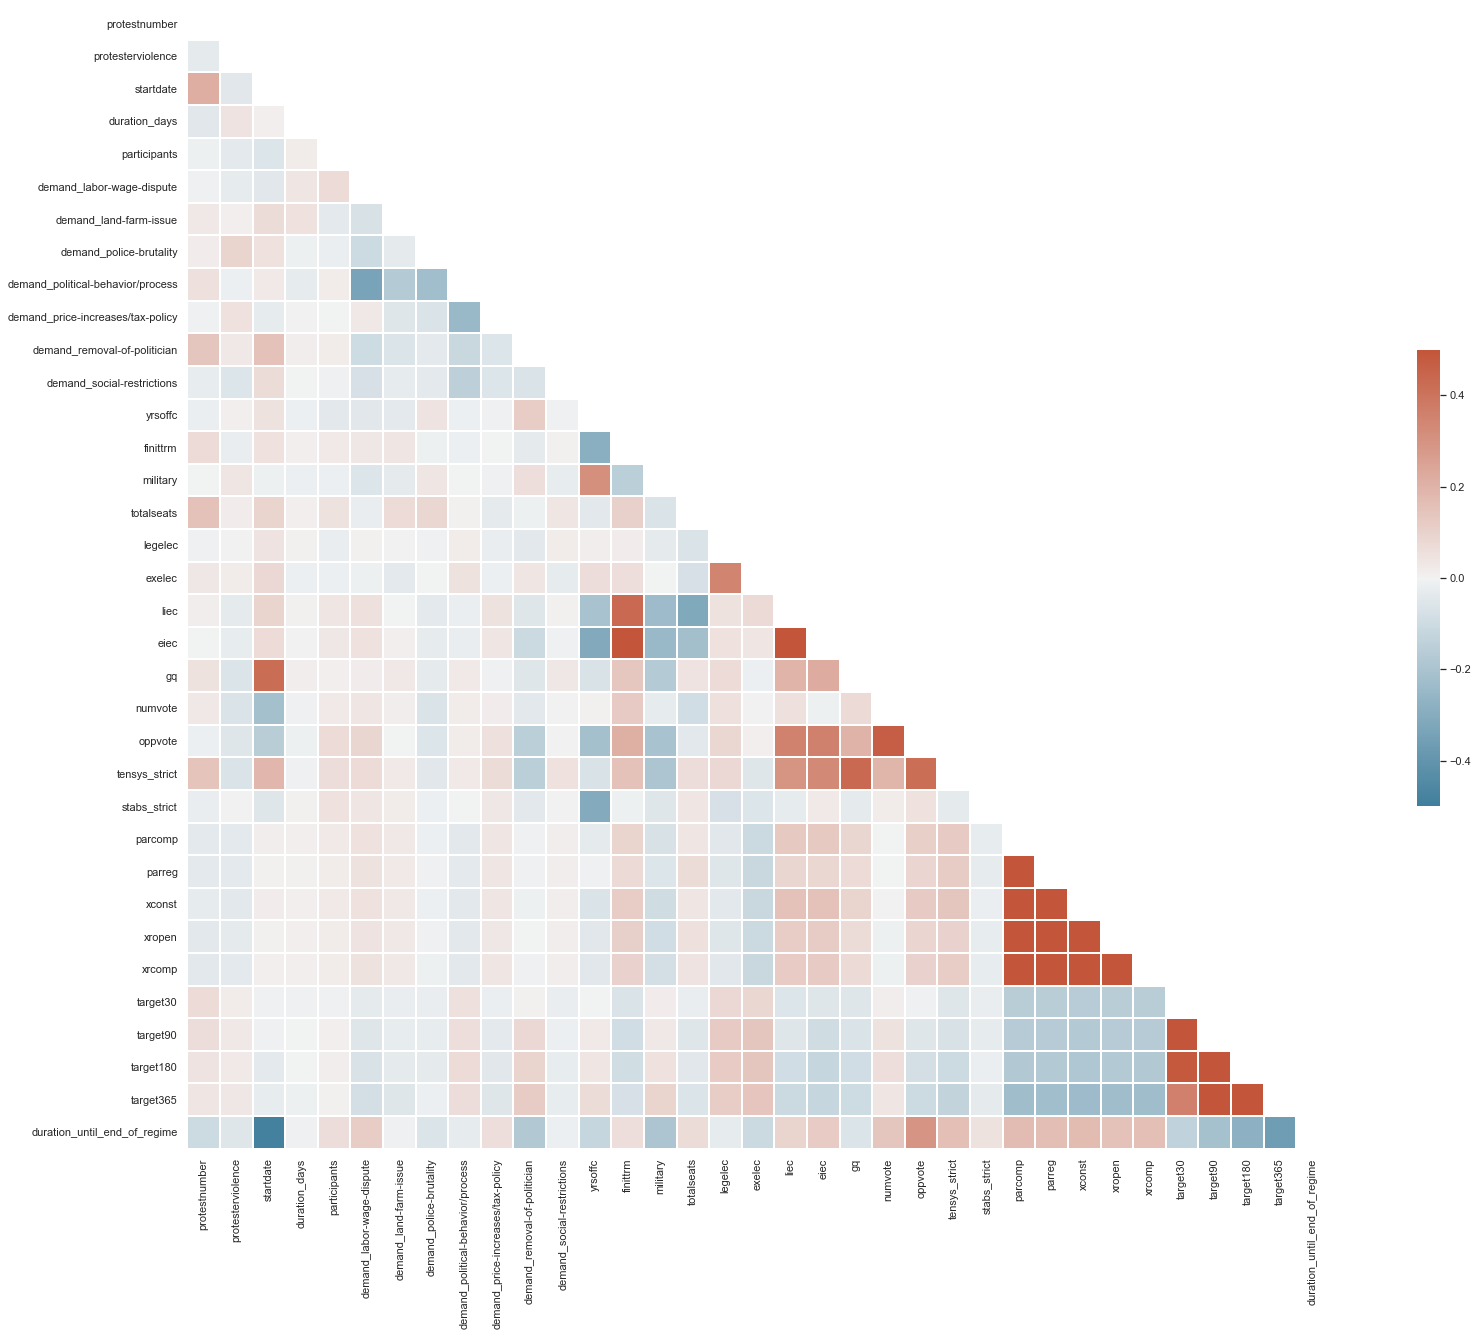

In [4]:
custom_plot_matrix(df, max_corr=0.5)

### Protestnumber

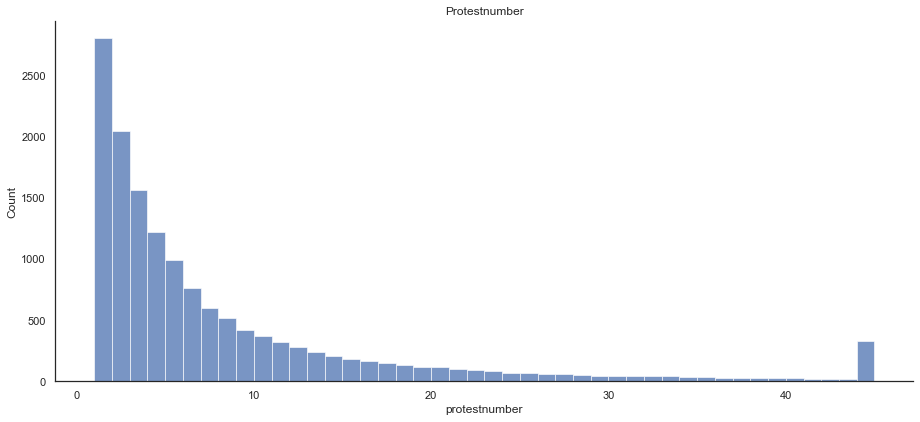

In [5]:
fig = sns.displot(df.protestnumber, bins=(df.protestnumber.max() - df.protestnumber.min()))
fig.fig.set_figwidth(15)
fig.fig.set_figheight(6)
plt.title('Protestnumber');

### Protest start year

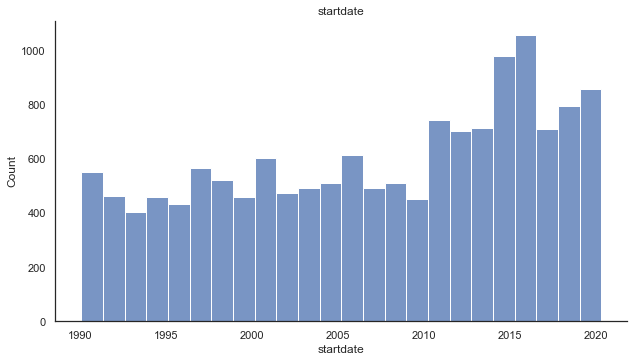

In [6]:
fig = sns.displot(df.startdate)
fig.fig.set_figwidth(10)
fig.fig.set_figheight(5)
plt.title('startdate');

### Protest duration

Value counts (top 10):
 1     12599
2       700
3       299
4       157
5       107
8        69
6        64
7        50
9        41
15       36
Name: duration_days, dtype: int64


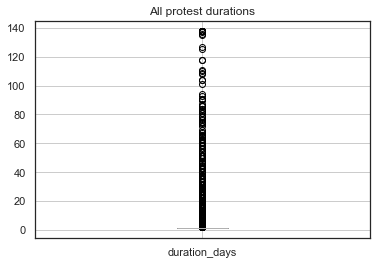

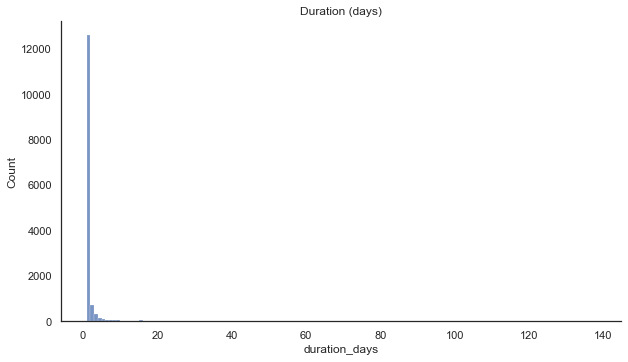

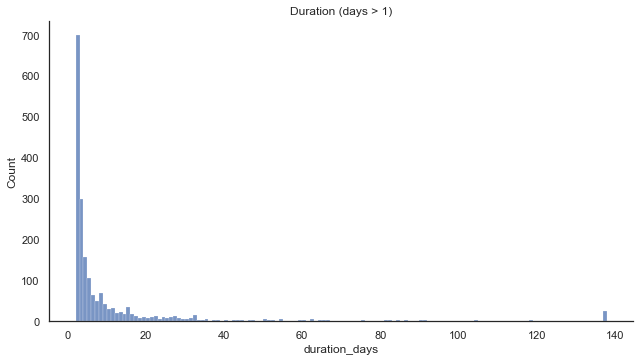

In [7]:
# Boxplot
print('Value counts (top 10):\n', df.duration_days.value_counts()[:10])
plt.figure()
pd.DataFrame(df.duration_days).boxplot()
plt.title('All protest durations')

# All values
fig = sns.displot(df.duration_days, bins=(df.duration_days.max() - df.duration_days.min()))
fig.fig.set_figwidth(10)
fig.fig.set_figheight(5)
plt.title('Duration (days)');


# All values > 1
more_than_one_day = df.loc[df.duration_days>1, 'duration_days']
fig = sns.displot(more_than_one_day, bins=(more_than_one_day.max() - more_than_one_day.min()))
fig.fig.set_figwidth(10)
fig.fig.set_figheight(5)
plt.title('Duration (days > 1)');

### Participant counts

Value counts (top 20):
 50        3095
100       2496
1000      2199
10000     1033
200        426
2000       379
549        338
500        312
300        301
5000       288
3000       252
3499       214
7500       203
20000      186
100000     180
150        142
357183     140
400        134
4000       132
74         111
Name: participants, dtype: int64


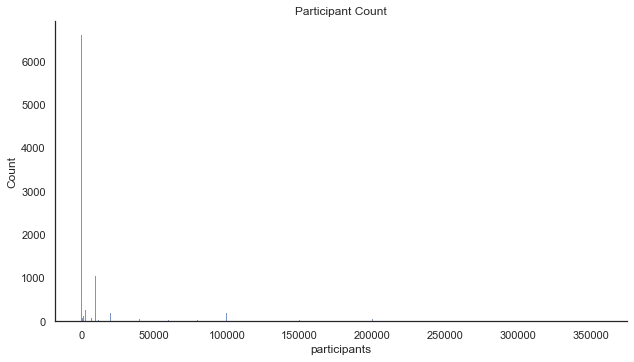

In [8]:
# Participant count
print('Value counts (top 20):\n', df.participants.value_counts()[:20])

fig = sns.displot(df.participants)
fig.fig.set_figwidth(10)
fig.fig.set_figheight(5)
plt.title('Participant Count');

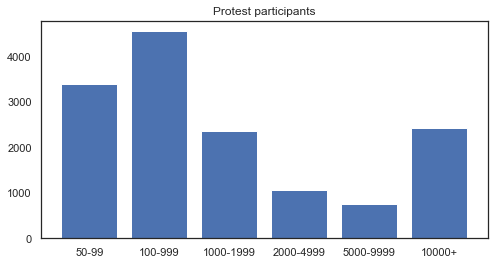

In [9]:
categories = ['50-99', '100-999', '1000-1999', '2000-4999', '5000-9999', '10000+']
participants = []

lookup = dict(df.participants_category.value_counts())
for category in categories:
    participants.append(lookup[category])

plt.figure(figsize=(8, 4))
plt.title('Protest participants')
plt.bar(categories, participants);

### Protester Demands

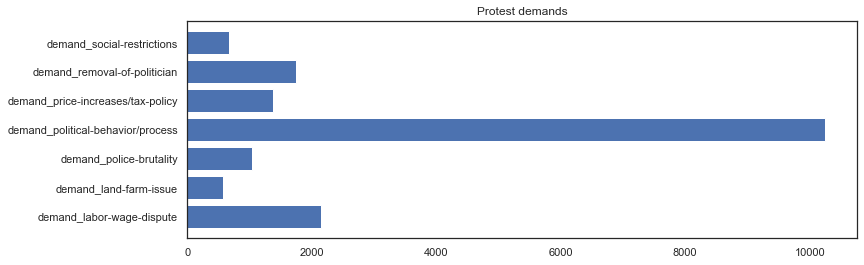

In [10]:
plt.figure(figsize=(12, 4))
plt.barh(df[demands].sum().index, df[demands].sum().values)
plt.title('Protest demands');

 **Target:** We see that the protester demand for "removal of politician" is most strongly correlated with an impending revolution. 
 
 **Alternative target:** We see that the rem

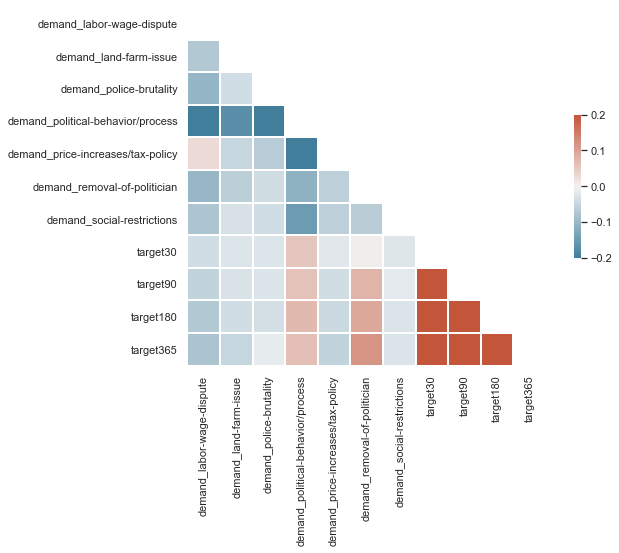

In [11]:
custom_plot_matrix(df[demands+targets], max_corr=0.2)

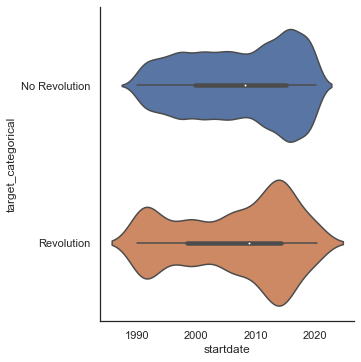

In [12]:
sns.catplot(x='startdate', y='target_categorical',kind="violin", data=df);

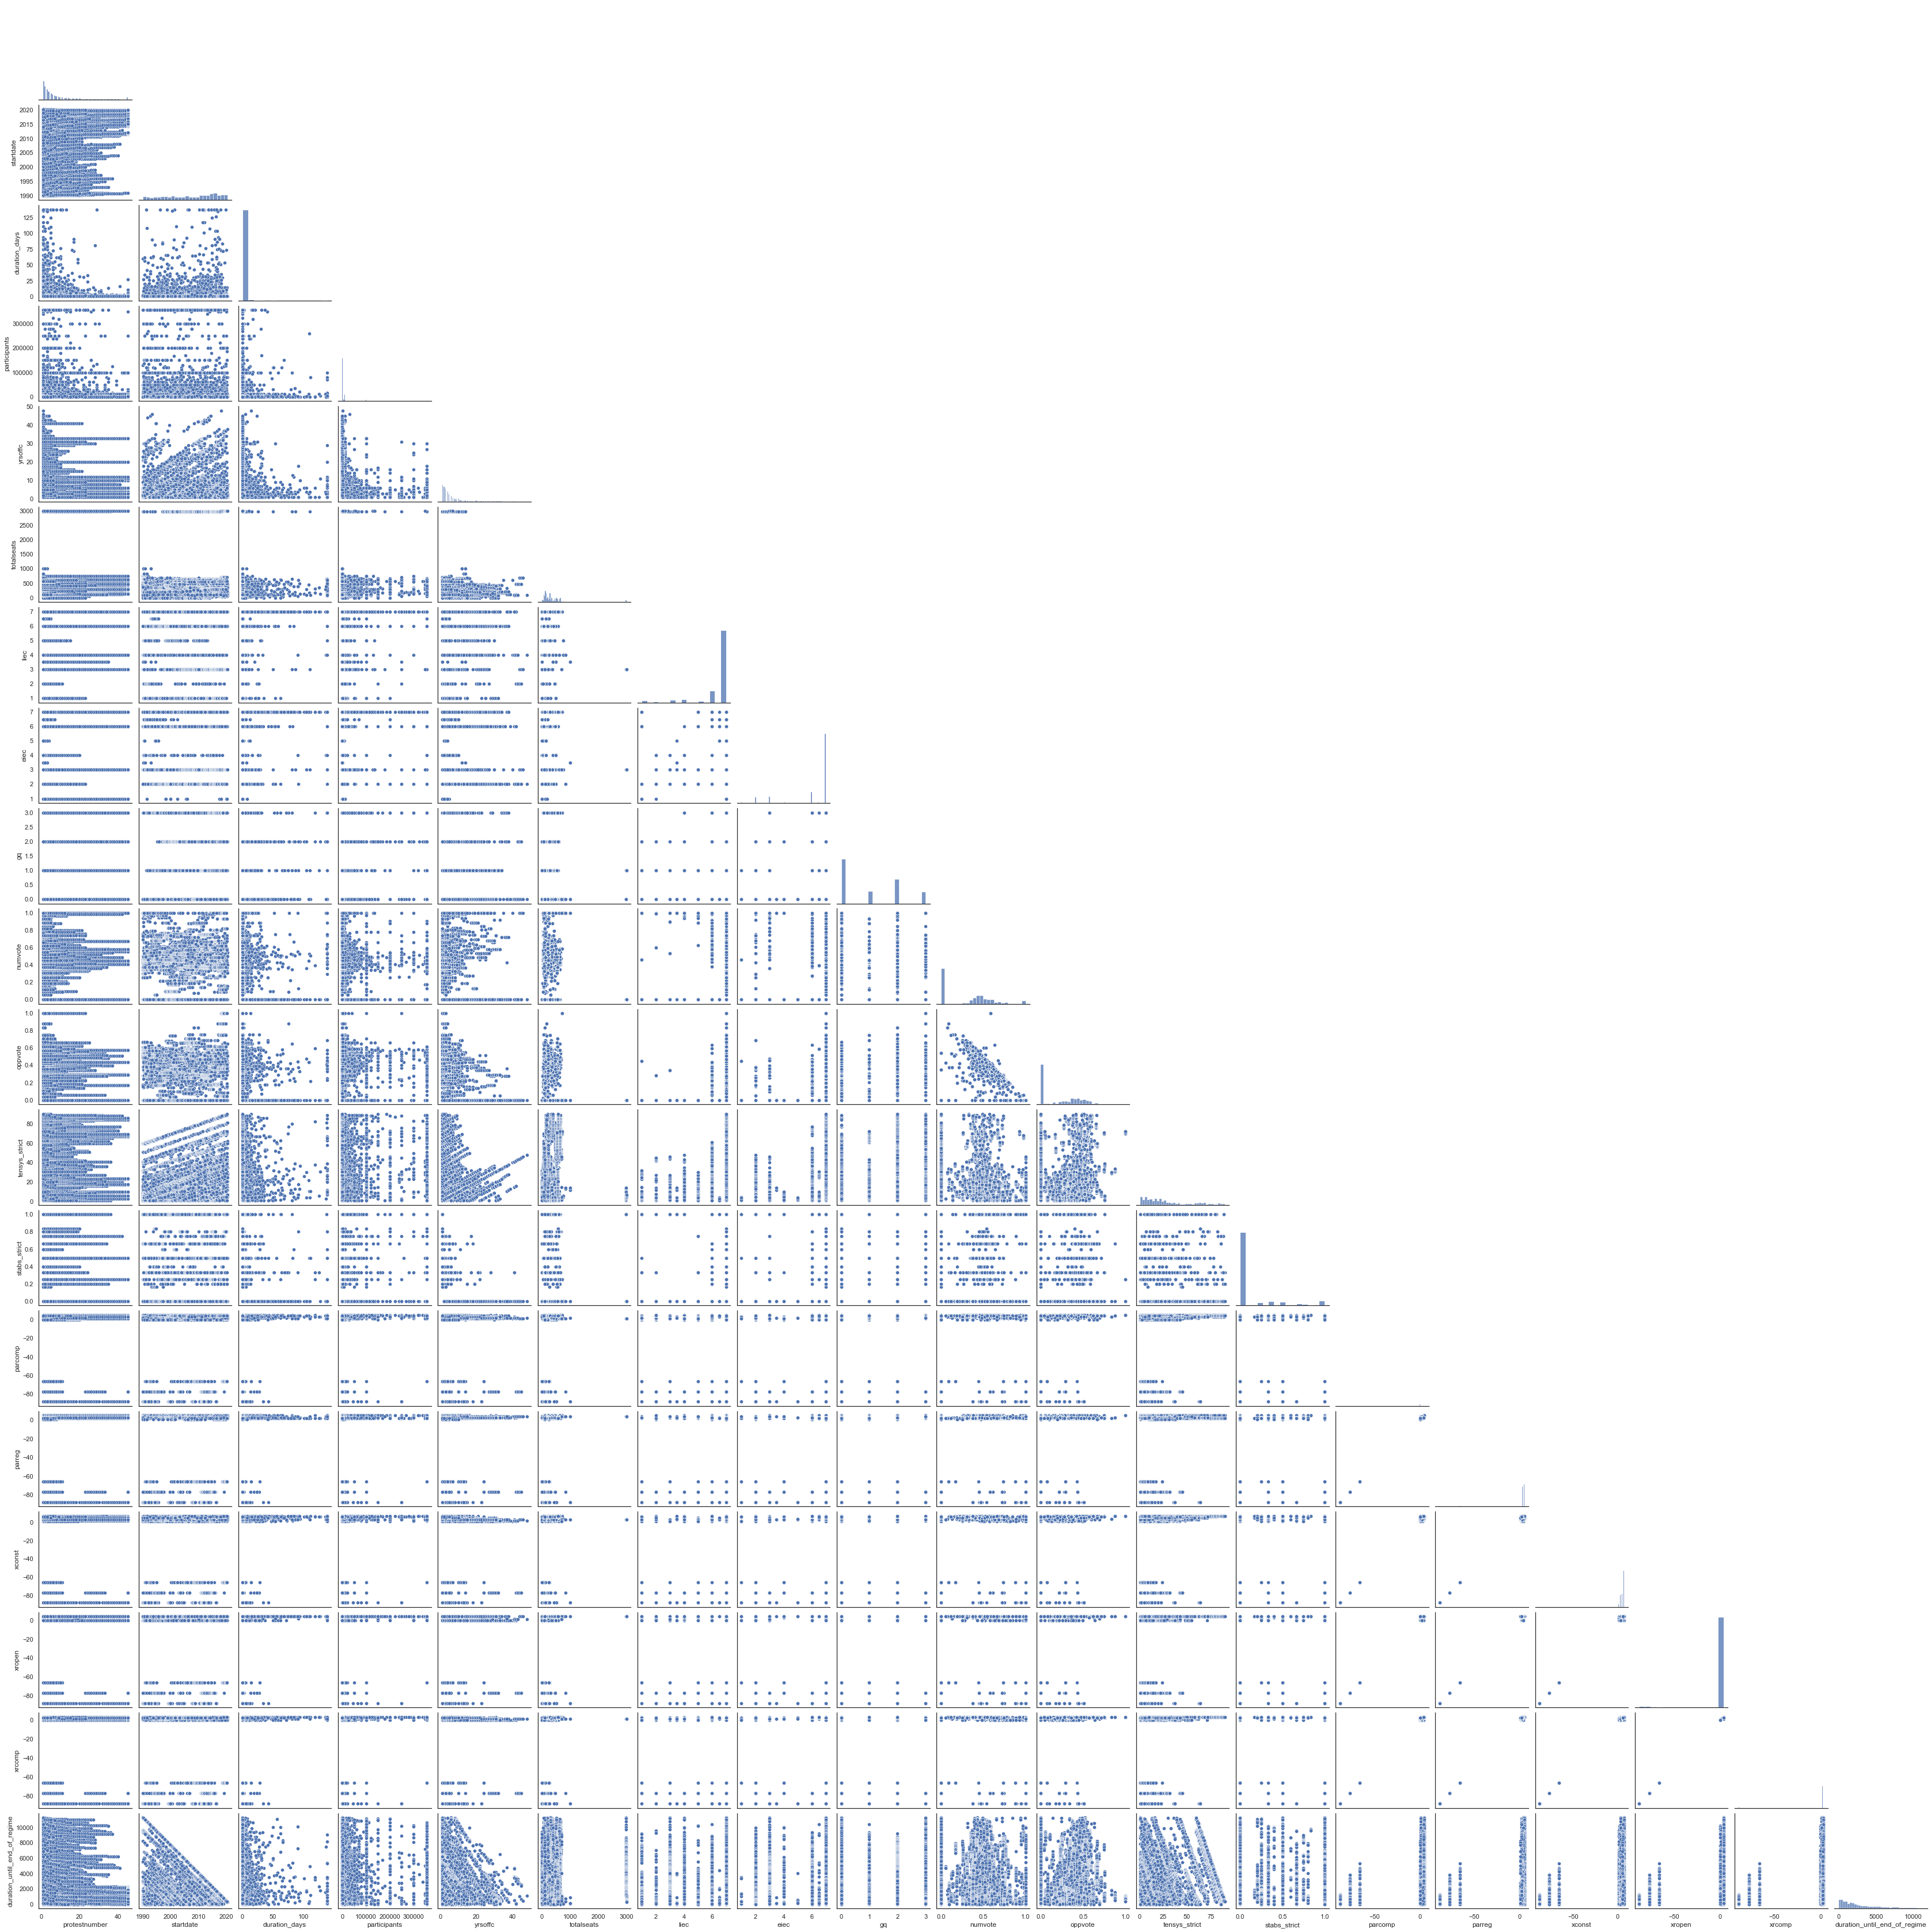

In [13]:
sns.pairplot(df.drop(binary+categorical+targets, axis=1), corner=True);

In [14]:
continuous

['protestnumber',
 'duration_days',
 'participants',
 'yrsoffc',
 'totalseats',
 'startdate',
 'liec',
 'eiec',
 'numvote',
 'oppvote',
 'gq',
 'tensys_strict',
 'stabs_strict',
 'duration_until_end_of_regime']

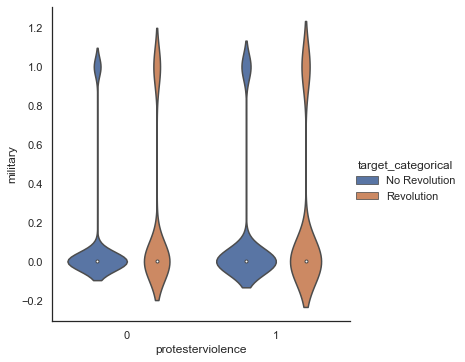

In [15]:
sns.catplot(y='military', x='protesterviolence',kind="violin", hue='target_categorical', data=df);



#plt.scatter(data=df, x='startdate', y='participants')

In [16]:
continuous

['protestnumber',
 'duration_days',
 'participants',
 'yrsoffc',
 'totalseats',
 'startdate',
 'liec',
 'eiec',
 'numvote',
 'oppvote',
 'gq',
 'tensys_strict',
 'stabs_strict',
 'duration_until_end_of_regime']

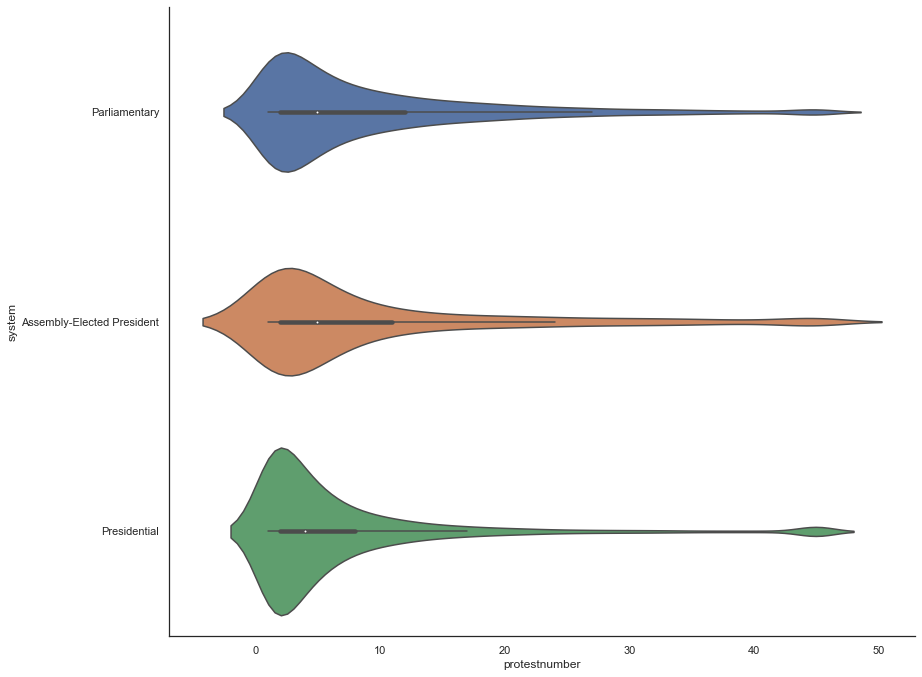

In [17]:
fig = sns.catplot(x='protestnumber', y='system',kind="violin", data=df)

fig.fig.set_figwidth(20)
fig.fig.set_figheight(10)

In [18]:
df.yrsoffc.mean()+3*df.yrsoffc.std()

25.775813787430792

In [19]:
high_end = df.totalseats.mean()+3*df.totalseats.std()
print('High end:', high_end)
df.loc[df.totalseats>high_end].totalseats.value_counts()

High end: 1656.5267774864517


2987.0    136
2978.0    117
3000.0     65
Name: totalseats, dtype: int64

In [20]:
df.totalseats.value_counts().head(30)

120.0     618
166.0     411
300.0     407
577.0     401
500.0     350
0.0       348
450.0     269
150.0     264
290.0     257
299.0     241
128.0     217
650.0     200
72.0      177
631.0     171
543.0     168
350.0     154
301.0     152
101.0     148
630.0     146
550.0     143
296.0     140
360.0     140
645.0     137
2987.0    136
400.0     133
130.0     126
513.0     125
207.0     122
2978.0    117
460.0     114
Name: totalseats, dtype: int64

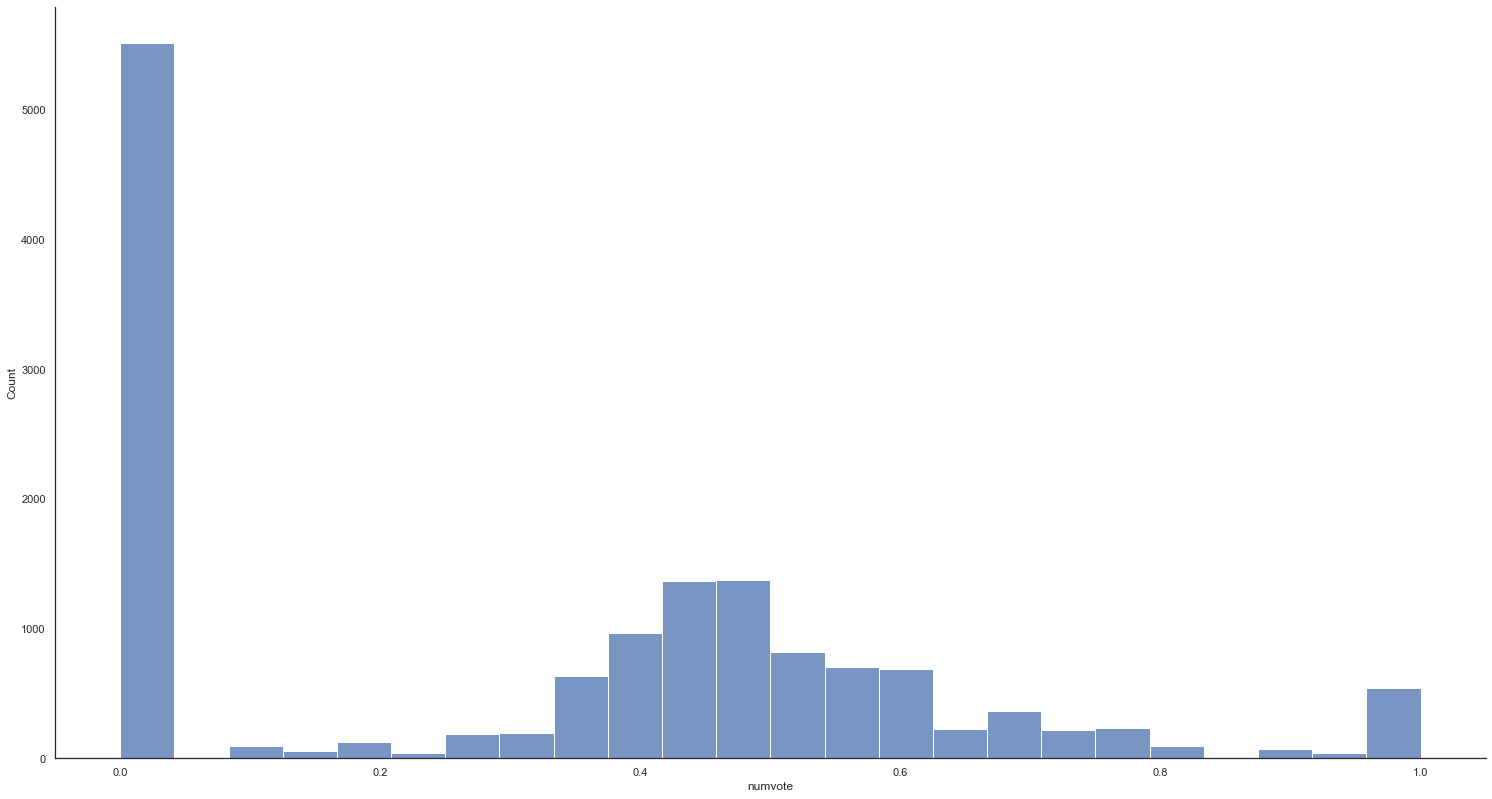

In [21]:
fig = sns.displot(df.numvote)
fig.fig.set_figwidth(25)
fig.fig.set_figheight(12.5)

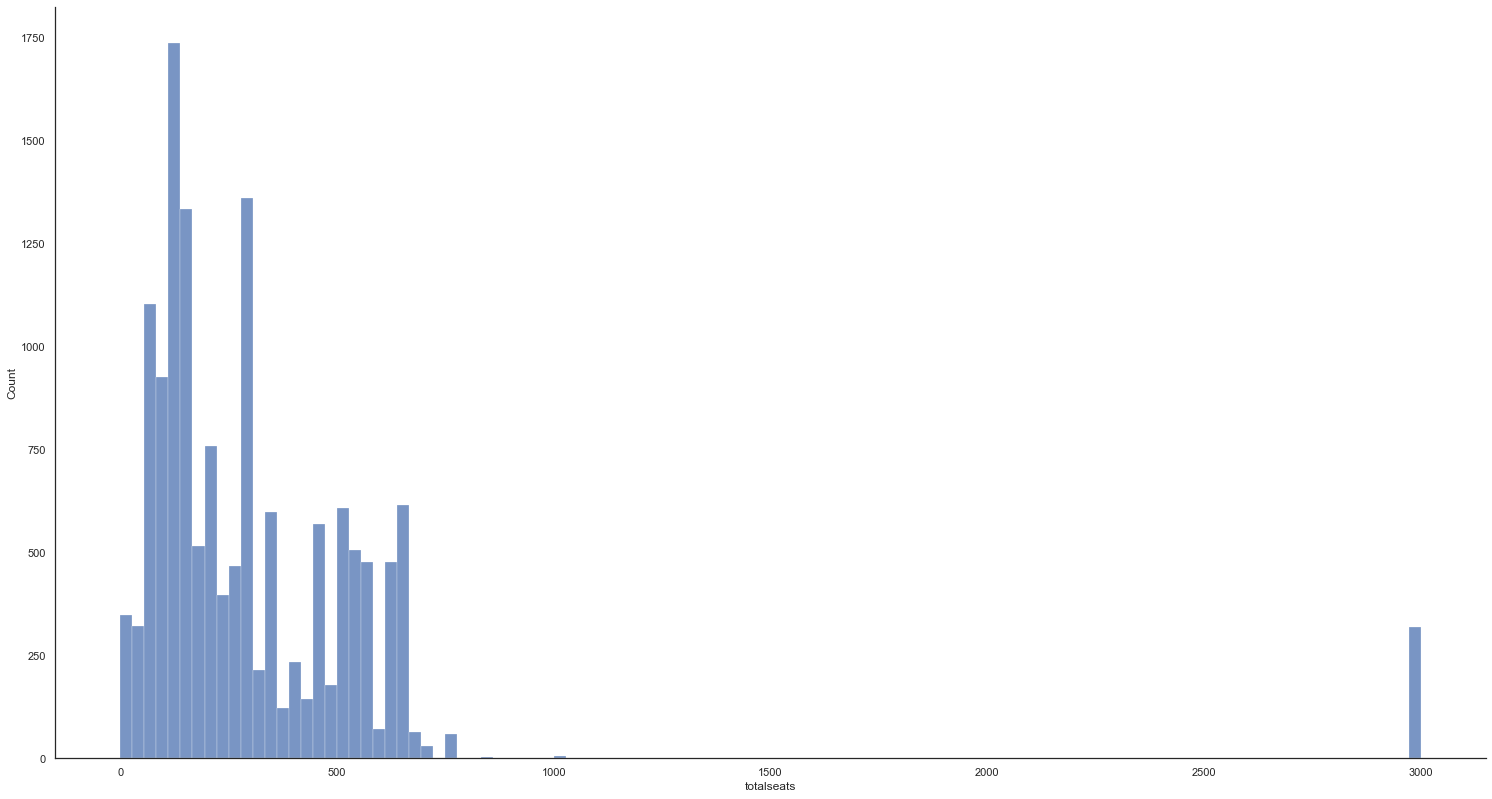

In [22]:
fig = sns.displot(df.totalseats)
fig.fig.set_figwidth(25)
fig.fig.set_figheight(12.5)

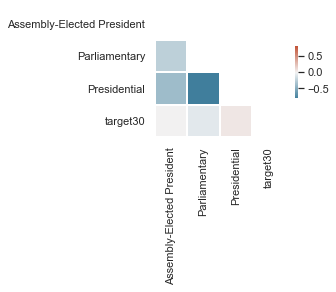

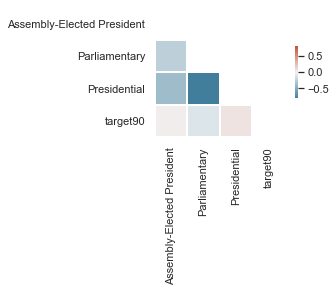

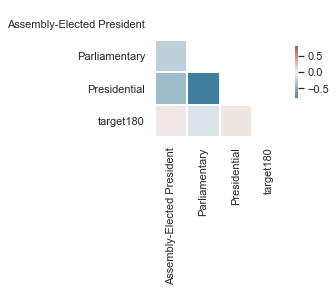

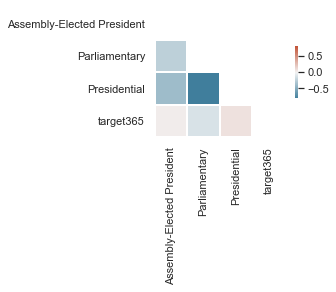

In [23]:
custom_plot_matrix(pd.concat([pd.get_dummies(df.system), df['target30']], axis=1))
custom_plot_matrix(pd.concat([pd.get_dummies(df.system), df['target90']], axis=1))
custom_plot_matrix(pd.concat([pd.get_dummies(df.system), df['target180']], axis=1))
custom_plot_matrix(pd.concat([pd.get_dummies(df.system), df['target365']], axis=1))

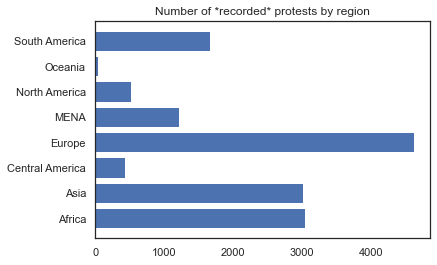

In [24]:
protest_ct = pd.get_dummies(df.region).sum()
plt.barh(protest_ct.index, protest_ct.values)
plt.title('Number of *recorded* protests by region');

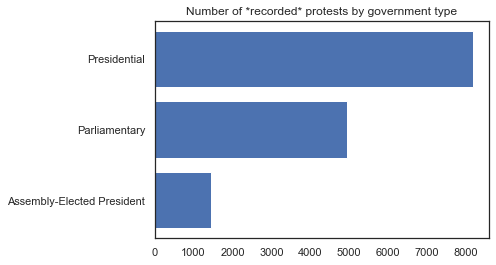

In [25]:
protest_ct = pd.get_dummies(df.system).sum()
plt.barh(protest_ct.index, protest_ct.values)
plt.title('Number of *recorded* protests by government type');

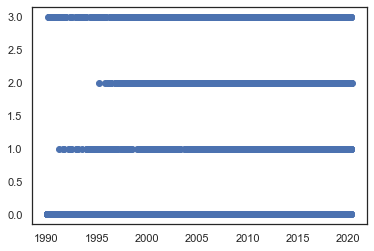

In [26]:
plt.scatter(df.startdate, df.gq)

In [27]:
continuous

['protestnumber',
 'duration_days',
 'participants',
 'yrsoffc',
 'totalseats',
 'startdate',
 'liec',
 'eiec',
 'numvote',
 'oppvote',
 'gq',
 'tensys_strict',
 'stabs_strict',
 'duration_until_end_of_regime']

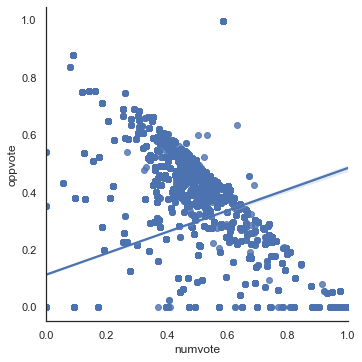

In [28]:
sns.lmplot(x='numvote', y='oppvote', data=df)

In [29]:
# NOTE THAT SETTING THESE PARAMETERS ELIMINATES "MASK" FUNCTIONALITY ON CMAP
FONT_SIZE=15
sns.set(rc={
    'figure.figsize': (20, 10),
    'font.size': FONT_SIZE,
    'axes.titlesize': FONT_SIZE, 
    'xtick.labelsize': FONT_SIZE, 
    'ytick.labelsize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE})

90.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
75.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
87.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
69.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


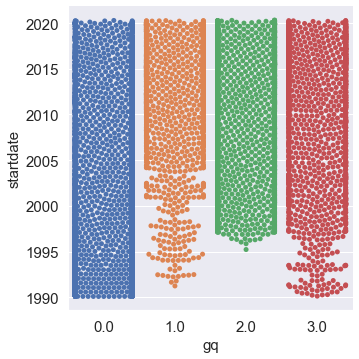

In [30]:
#"strip", "swarm", "box", "violin", "boxen", "point", "bar", or "count".
sns.catplot(y='startdate', x='gq',kind="swarm", data=df);

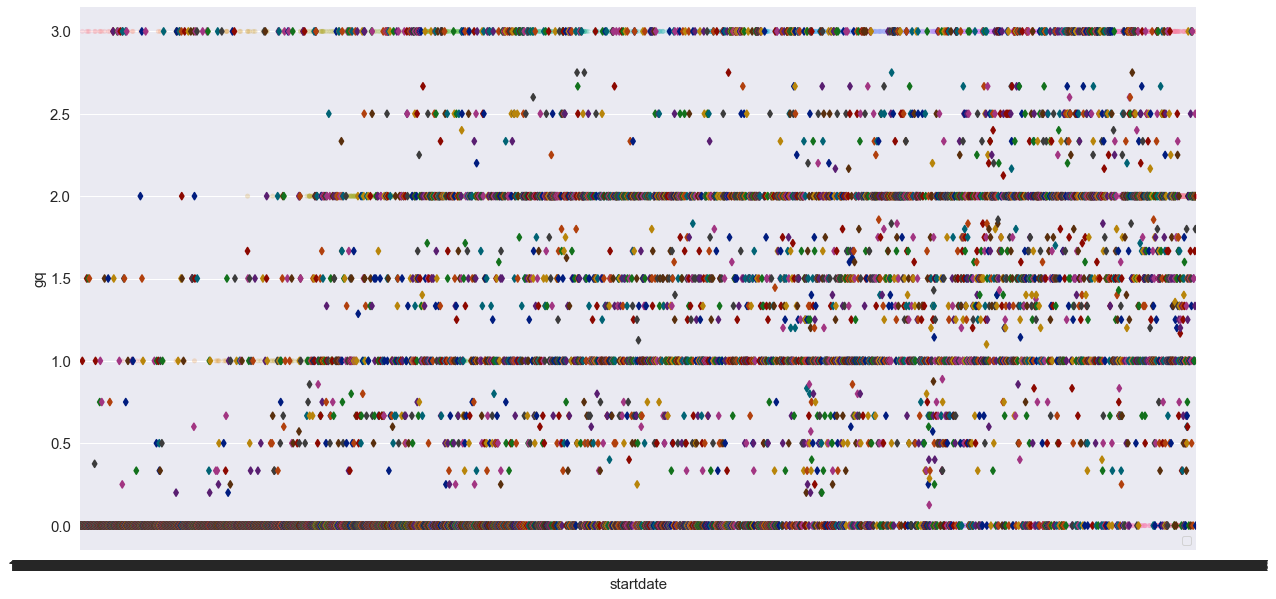

In [31]:
df_cut = df[['gq', 'startdate']]#, 'target365']]
df_melt = df_cut.copy()

#iris = pd.melt(df_melt, var_name="gq")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="startdate", y="gq",# hue="species",
              data=df_melt, dodge=True, alpha=.25, zorder=1)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(x="startdate", y="gq",# hue="species",
              data=df_melt, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)


# Improve the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:],# title="species",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

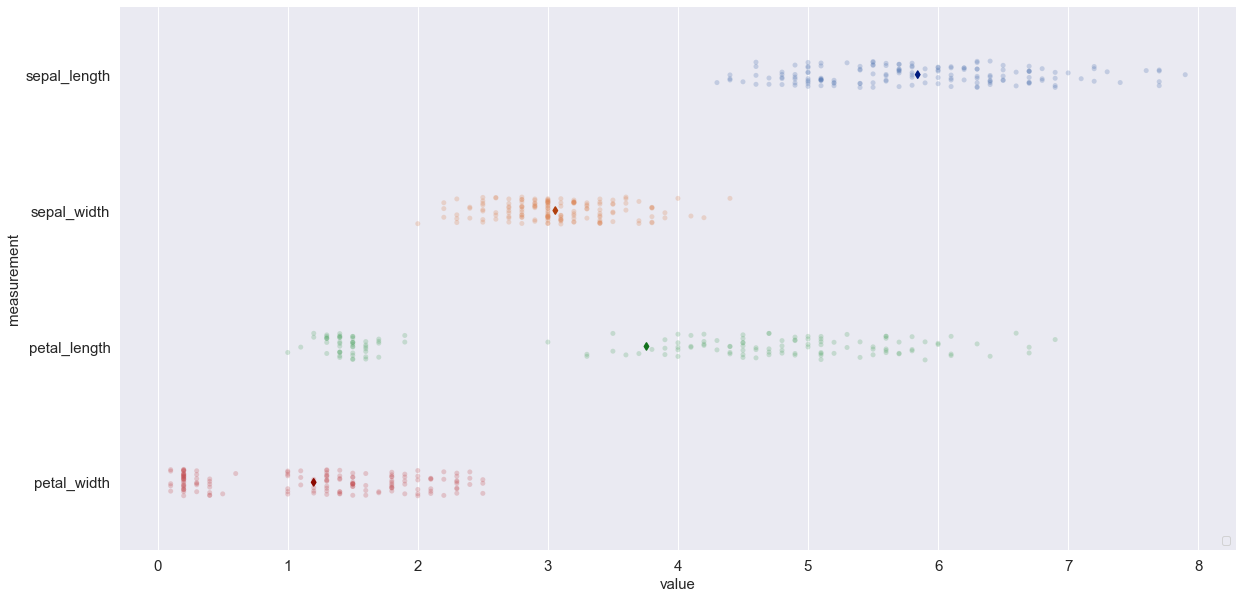

In [32]:
iris = sns.load_dataset("iris")

# "Melt" the dataset to "long-form" or "tidy" representation
iris = pd.melt(iris, "species", var_name="measurement")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="value", y="measurement",# hue="species",
              data=iris, dodge=True, alpha=.25, zorder=1)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(x="value", y="measurement",# hue="species",
              data=iris, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)


# Improve the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:],# title="species",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)